CNN1D model used for inharmonic stimuli

In [ ]:
!pip install torch==1.7.0
!pip install torchaudio==0.7.0
!pip install torchvision
import torch
import torchaudio
import torchvision


In [ ]:
import scipy
import os
import numpy as np
from scipy.ndimage import zoom
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab_Notebooks')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
class toOneHot(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, integer):
        y_onehot = torch.zeros(self.num_classes)
        y_onehot[integer]=1
        return y_onehot

In [ ]:
# Write my own data structure
class MyTrainingDataset(Dataset):
  def __init__(self, root, transform=None, target_transform=None):
    self.root = root
    self.transform = transform
    self.target_transform = target_transform
    # self.data = np.load(self.root + '/waveform.npy', allow_pickle=True)
    self.data = np.expand_dims(np.load(self.root + '/waveform.npy'), axis=1)
    self.targets = np.squeeze(np.load(self.root + '/target.npy', allow_pickle=True).astype(int))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, n):
    sample = self.data[n]
    target = self.targets[n]
    if self.transform:
        sample = self.transform(sample)
    if self.target_transform:
        target = self.target_transform(target)
    return sample, target

root = '/content/drive/MyDrive/Colab_Notebooks'

In [ ]:
# Load the training set
train_set = MyTrainingDataset('/content/drive/MyDrive/Colab_Notebooks/inharmo',
                              transform=transforms.Compose([transforms.ToTensor()]),
                              target_transform=None,)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
# Load the test set
test_set = MyTrainingDataset('/content/drive/MyDrive/Colab_Notebooks/inharmo/test',
                             transform=transforms.Compose([transforms.ToTensor()]),
                             target_transform=None,)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True)

In [ ]:
class CNN1D(torch.nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = torch.nn.Conv1d(1,300, kernel_size=2, stride=1)
        self.conv2 = torch.nn.Conv1d(300, 110, 4, 1)
        self.dropout1 = torch.nn.Dropout(p = .25)
        self.dropout2 = torch.nn.Dropout(p = 0.5)
        self.pool = torch.nn.MaxPool1d((2))
        self.fc1 = torch.nn.Linear(1455080,2)
    def forward(self, x):
        x = torch.squeeze(x, axis=1).float()
        x = self.conv1(x)
        x = torch.relu(x)
        x= self.conv2(x)
        x = self.pool(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
net = CNN1D().cuda()

In [ ]:
# loss function
mse_loss = torch.nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
def train_step(x,t,net,opt_fn,loss_fn):
  y = net(x.cuda())
  loss = loss_fn(y, t.cuda())
  loss.backward()
  opt_fn.step()
  opt_fn.zero_grad()
  return loss 

In [ ]:
x,t = next(iter(train_loader))
loss_ = train_step(x, t, net, opt, mse_loss)

In [ ]:
y = net(x.cuda())
y.shape

torch.Size([50, 2])

In [ ]:
# Train the network over multiple epochs
train_acc = []
test_acc = []
for epoch in range(50):
  batch_acc = []
  for x,t in iter(train_loader):
      loss_ = train_step(x,t,net,opt, mse_loss)
      y = net(x.cuda()).cpu()
      batch_acc.append(torch.mean((t==y.argmax(1)).float()))
  train_acc.append(torch.mean(torch.FloatTensor(batch_acc)))   
  print(loss_)

  batch_acc = []
  for x,t in iter(test_loader):   
      y = net(x.cuda()).cpu()
      batch_acc.append(torch.mean((t == y.argmax(1)).float()))
  test_acc.append(torch.mean(torch.FloatTensor(batch_acc))) 

tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6912, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6865, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6897, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6864, device='cuda:0', grad_fn=<NllLossBackward

In [ ]:
train_acc

[tensor(0.4840),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320),
 tensor(0.5320)]

In [ ]:
test_acc

[tensor(0.4400),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600),
 tensor(0.5600)]

Text(0.5, 1.0, 'CNN1D Inharmonic')

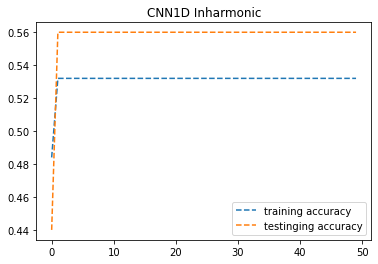

In [ ]:
plt.figure()
plt.plot(train_acc, ls = '--', label = 'training accuracy')
plt.plot(test_acc, ls = '--',label = 'testinging accuracy')
plt.legend(loc='best')
plt.title('CNN1D Inharmonic')